In [194]:
"""Preprocess text extracted from scholarly articles into keyphrase candidates.       

The expected input is a list of text extracted from scholarly papers published in Russian from
the dialog conference. The first step is to remove the reference section and any unusually short
paragraphs. Then, parenthesized and bracketed text are removed, as well as any words that happen
to be cut off at a new page boundary.

The text is then tokenized using the preprocessing and tokenization technique developed by 
WebVectores [Kutuzov 2017]. At this point, documents in the corpus are transformed into
lists of tokens corresponding to the paragraphs in the document. Tokens are unigrams of lowercased
lemmas or punctuation marks.

Each document is then broken into sentences, and n-grams are added. This results in each document
being transformed into a list of sentence tokens, which may be unigrams, bigrams, or trigrams.
Finally, the sentence tokens are filtered to remove any unusually short or long tokens and stop
words. The document is flattened, resulting in it being transformed into a list of keyphrase 
candidate tokens.

Typical usage example:

    file_names = get_file_names("../data/raw_txt/2010/ru", ".txt")
    corpus = [get_text(name) for name in file_names]
    corpus = ScholarlyPreprocessor.preprocess(corpus, file_names)
"""

# Reset the kernel (ipython magic command)
%reset -f

## How to load the preprocessed data

In [196]:
from pathlib import Path
from topic_modeling import TopicModeler


# Load the preprocessed corpus
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
corpus = TopicModeler.load_corpus(year_range, input_dir)

# Create an id-token mapping for the vocabulary
dictionary = TopicModeler.create_dictionary(corpus)
print("Dictionary:\n", dictionary)

# Create the document-token frequency (Bag-of-Words) representation of the corpus
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
print("-"*50, "\n\nBag-of-Words, first 20 tokens in the first document:\n", bow_corpus[0][:20])

2020-07-19 14:32:18,931 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2006.pickle
2020-07-19 14:32:18,965 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2007.pickle
2020-07-19 14:32:18,995 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2008.pickle
2020-07-19 14:32:19,021 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2009.pickle
2020-07-19 14:32:19,044 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2010.pickle
2020-07-19 14:32:19,072 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\data\preprocessed\2011.pickle
2020-07-19 14:32:19,086 : INFO : Loading preprocessed text from C:\Users\Whyve\Projects\auto-keyphrase-extraction-ru\d

Dictionary:
 Dictionary(11562 unique tokens: ['1-е', 'автоматический', 'актер', 'актуализация', 'анализ']...)
-------------------------------------------------- 

Bag-of-Words, first 20 tokens in the first document:
 [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


## Optimize the number of latent topics

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_num_topics, TopicModeler


# Parameters
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/num_topics").resolve())
repetitions = 10
candidate_num_topics = range(2, 16)

corpus = TopicModeler.load_corpus(year_range, input_dir)
dictionary = TopicModeler.create_dictionary(corpus)
bow_corpus = TopicModeler.create_bow(corpus, dictionary)
optimize_num_topics(candidate_num_topics, corpus, dictionary, bow_corpus, 
                    target, repetitions=repetitions)

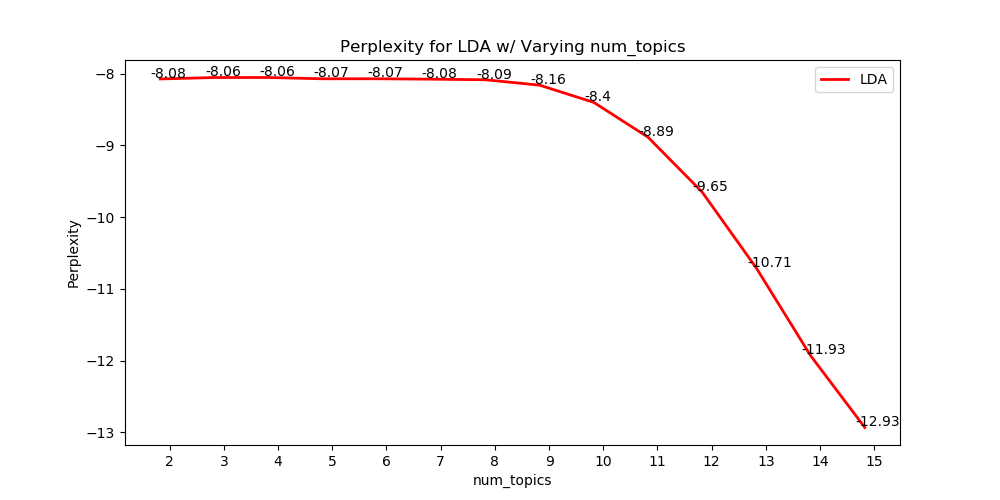

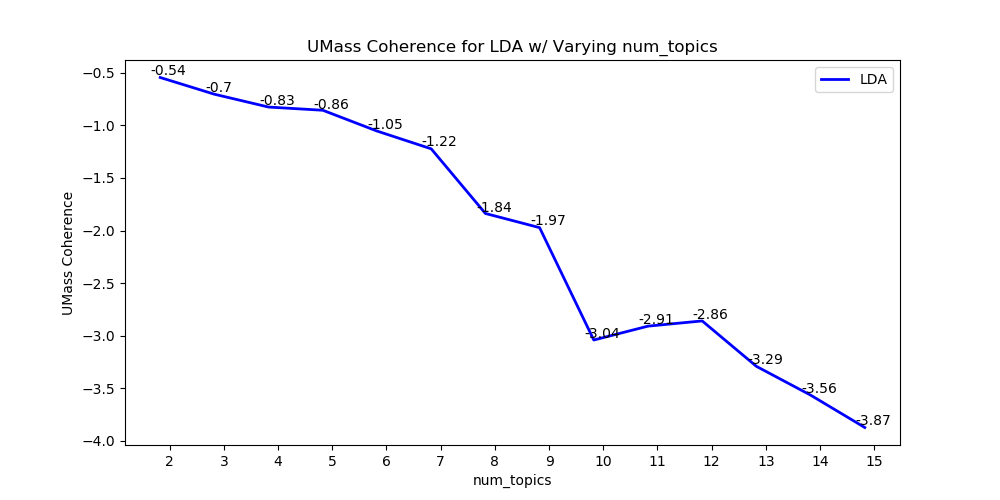

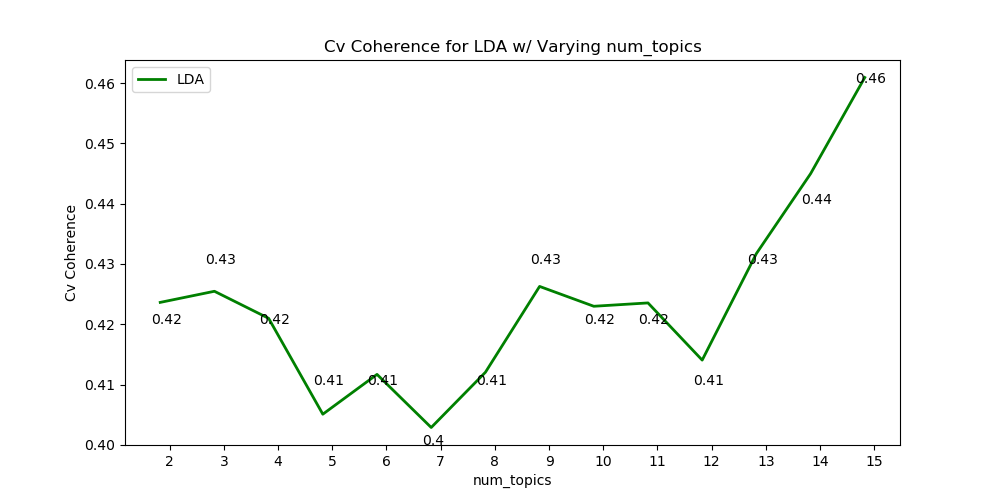

In [4]:
from IPython.display import Image
from pathlib import Path


# Show the results of optimizing num_topics
input_dir = str(Path("../data/LDA/num_topics/").resolve())
display(Image(str(Path(input_dir, "num_topics-perplexity.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_umass.png"))))
display(Image(str(Path(input_dir, "num_topics-coherence_cv.png"))))

## Optimize no_above

In [ ]:
# Note: This will not work through jupyter notebook one Windows due to the multiprocessing
# module used for calculating Cv Coherence. Run these commands in a python shell.

from pathlib import Path
from topic_modeling import optimize_no_above, TopicModeler


# Parameters
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/no_above").resolve())
repetitions = 10
num_topics = 5
candidate_no_above= [i/100 for i in range(50, 100, 5)]

corpus = TopicModeler.load_corpus(year_range, input_dir)
optimize_no_above(candidate_no_above, corpus, target,
                  repetitions=repetitions, num_topics=num_topics)

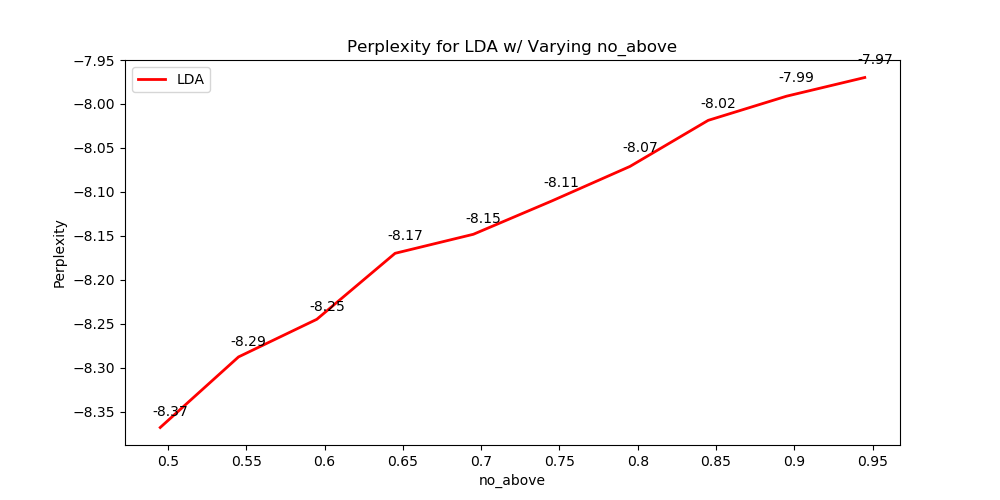

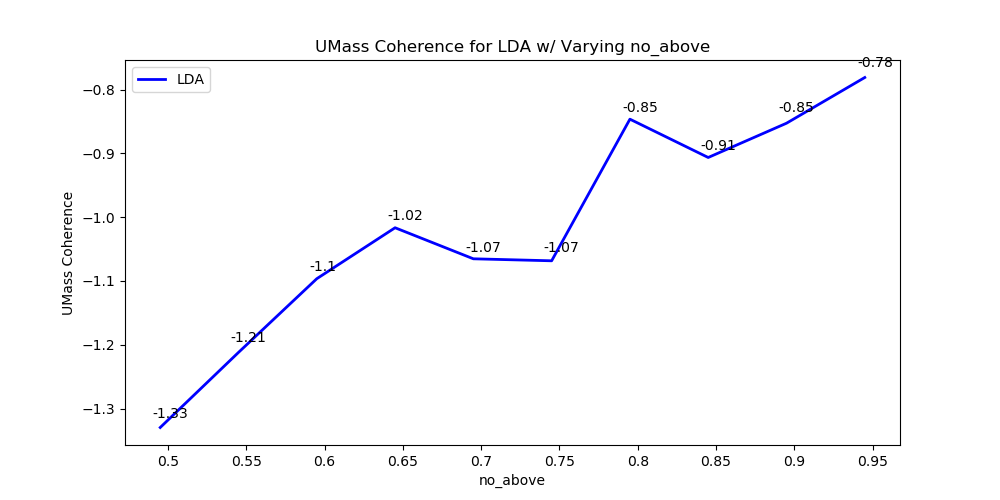

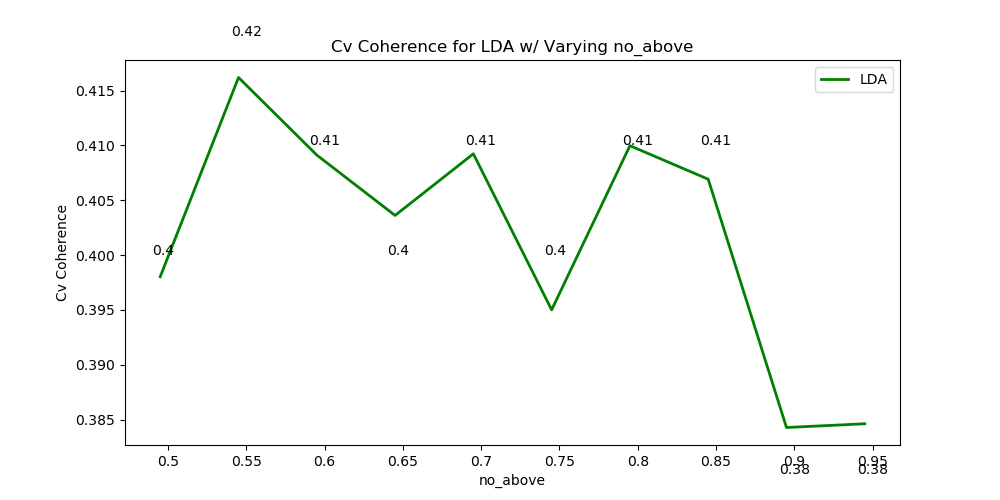

In [6]:
from IPython.display import Image
from pathlib import Path

# Show the results of optimizing no_above
input_dir = str(Path("../data/LDA/no_above/").resolve())
display(Image(str(Path(input_dir, "no_above-perplexity.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_umass.png"))))
display(Image(str(Path(input_dir, "no_above-coherence_cv.png"))))

## Run LDA with the optimized parameters

In [99]:
from helpers import get_file_names
from pathlib import Path
from topic_modeling import TopicModeler

import logging
import os
import pickle


num_topics = 7
no_above = .8
num_words = 7

target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)

# Load the preprocessed corpus
year_range = range(2006, 2021)
input_dir = str(Path("../data/preprocessed").resolve())
entire_corpus = []
cur_corpus = []
for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
        entire_corpus.extend(cur_corpus)
    
    # Create and save the LDA model for each year
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
    lda_model.save(str(Path(target, str(year) + ".gensim")))
    
    # Print the learned topics and the top associated keyphrases
    print("-"*50, "\nTopics for", str(year) + ":")
    TopicModeler.print_topics(lda_model, num_words=num_words)
    cur_corpus = None

dictionary = TopicModeler.create_dictionary(entire_corpus, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus, dictionary)
lda_model = TopicModeler.train_lda(bow_corpus, dictionary, num_topics=num_topics)
lda_model.save(str(Path(target, "all.gensim")))
print("-"*50, "\nTopics for entire dialog corpus:")
TopicModeler.print_topics(lda_model, num_words=num_words)

-------------------------------------------------- 
Topics for 2006:


,Topic #,Top keywords
0,1,"речь, база, фраза, тема, естественный, оценка, фонема"
1,2,"текст, система, база, результат, длина, таблица, метод"
2,3,"значение, контекст, термин, словарь, глагол, группа, корпус"
3,4,"понятие, объект, связь, онтология, например, описание, информация"
4,5,"сравнивать, добрый, размер, употребление, конструкция, лексема, обозначать"
5,6,"документ, рубрика, запрос, источник, поиск, вес, словосочетание"
6,7,"пример, перевод, конструкция, выражение, объект, предложение, предмет"


-------------------------------------------------- 
Topics for 2007:


,Topic #,Top keywords
0,1,"корпус, диктор, речь, данные, анализ, основа, параметр"
1,2,"частица, предлог, клиент, мысль, сфера, вызывать, недавний"
2,3,"высказывание, диалог, жест, речь, сообщение, ответ, коммуникативный"
3,4,"предложение, структура, правило, тема, элемент, система, связь"
4,5,"текст, словарь, информация, лексема, интернет, сайт, перевод"
5,6,"ситуация, глагол, объект, контекст, конструкция, употребление, указывать"
6,7,"понятие, система, документ, кластер, словоформа, технология, словоформ"


-------------------------------------------------- 
Topics for 2008:


,Topic #,Top keywords
0,1,"объект, глагол, онтология, понятие, связь, отношение, действие"
1,2,"выбор, адресат, перевод, совпадать, обращение, опыт, эмоция"
2,3,"пауза, падение, уровень, акцент, тон, подъем, запись"
3,4,"термин, задача, система, словосочетание, результат, метод, список"
4,5,"пример, предложение, ситуация, контекст, конструкция, высказывание, прилагательное"
5,6,"жест, речевой, поведение, ответ, речевой поведение, тело, общение"
6,7,"корпус, словарь, речь, исследование, данные, материал, форма"


-------------------------------------------------- 
Topics for 2009:


,Topic #,Top keywords
0,1,"рисяча, сегмент, положение, сеть, продолжать, ссылка, вершина"
1,2,"корпус, поиск, словарь, интернет, название, лексика, современный"
2,3,"значение, ситуация, глагол, конструкция, семантика, существительное, контекст"
3,4,"жест, сравнивать, форма, тело, бывать, особенность, статья"
4,5,"предложение, правило, документ, получать, распределение, определять, модель"
5,6,"явление, автор, единица, заменять, речь, запись, выделять"
6,7,"объект, прилагательное, словарь, класс, шаблон, описание, данные"


-------------------------------------------------- 
Topics for 2010:


,Topic #,Top keywords
0,1,"тело, интерпретация, жест, высказывание, сведение, отличие, указание"
1,2,"речь, текст, вариант, форма, знак, программа, материал"
2,3,"эксперимент, гипотеза, документ, метод, фактор, классификация, сложность"
3,4,"значение, глагол, ситуация, предложение, сравнивать, контекст, выражение"
4,5,"словарь, метафора, описание, функция, информация, структура, значение"
5,6,"ссылка, сайт, блог, страница, поисковый система, тематика, популярный"
6,7,"текст, система, шаблон, предложение, задача, связь, подход"


-------------------------------------------------- 
Topics for 2011:


,Topic #,Top keywords
0,1,"глагол, сравнивать, различие, форма, называть, результат, характерный"
1,2,"идиома, употребление, ситуация, конструкция, контекст, употреблять, выражение"
2,3,"объект, информация, частица, функция, ожидание, языковой, связывать"
3,4,"жест, письмо, студент, высказывание, союз, герой, устный речь"
4,5,"местоимение, предикат, частица, предложение, выражать, показатель, обозначать"
5,6,"речь, термин, вариант, словарь, соответствовать, включать, ошибка"
6,7,"текст, предложение, корпус, автор, правило, результат, система"


-------------------------------------------------- 
Topics for 2012:


,Topic #,Top keywords
0,1,"метод, оценка, речь, эксперимент, совпадение, использование, получать"
1,2,"правило, фрагмент, выделение, адрес, формирование, начинать, шаг"
2,3,"союз, словарь, корпус, лексема, группа, разметка, существительное"
3,4,"ситуация, сравнивать, вариант, употребление, контекст, называть, автор"
4,5,"высказывание, частица, реплика, собеседник, пауза, коммуникативный, выражать"
5,6,"предложение, тема, глагол, признак, система, объект, структура"
6,7,"коммуникация, компьютер, интерфейс, информационный, искать, инструментарий, культурный"


-------------------------------------------------- 
Topics for 2013:


,Topic #,Top keywords
0,1,"глагол, прилагательное, существительное, форма, предложение, группа, частность"
1,2,"ситуация, употребление, фраза, контекст, смысл, адресат, текст"
2,3,"приставка, жест, материал, усилие, правый, ось, пере"
3,4,"данные, речь, признак, качество, информация, разный, задача"
4,5,"конструкция, субъект, глагол, тело, элемент, выражать, синтаксический"
5,6,"префикс, присоединение, увеличение, закон, обобщение, кандидат, записывать"
6,7,"текст, корпус, словарь, система, форма, частотный, оценка"


-------------------------------------------------- 
Topics for 2014:


,Topic #,Top keywords
0,1,"фильм, тема, встречаться, становиться, словарь, серия, следующий"
1,2,"существительное, глагол, вместо, вполне, очевидно, употребление, автор"
2,3,"контекст, предложение, объект, конструкция, наречие, группа, глагол"
3,4,"плохой, корпус, достигать, текст, данные, глагол, алгоритм"
4,5,"корпус, данные, текст, модификация, таблица, материал, форма"
5,6,"текст, рисяча, система, термин, плюс, модель, помощь"
6,7,"частица, ситуация, единица, отличие, идея, оборот, разный"


-------------------------------------------------- 
Topics for 2015:


,Topic #,Top keywords
0,1,"признак, объект, размер, выражение, форма, класс, лексема"
1,2,"возможность, определять, связь, разный, система, подход, отношение"
2,3,"жест, перевод, персонаж, акцент, передавать, коммуникация, рема"
3,4,"корпус, сочетание, словарь, форма, существительное, частотность, таблица"
4,5,"текст, речь, корпус, задача, модель, разметка, получать"
5,6,"частица, предложение, высказывание, единица, союз, речь, оказываться"
6,7,"глагол, бывать, употребление, конструкция, контекст, речь, компонент"


-------------------------------------------------- 
Topics for 2016:


,Topic #,Top keywords
0,1,"текст, оценка, корпус, искать, средний, пример, значение"
1,2,"отношение, название, вариант, ситуация, норма, указывать, следование"
2,3,"глагол, значение, конструкция, пример, событие, контекст, объект"
3,4,"плюс, эксперимент, частота, результат, параметр, данные, выборка"
4,5,"движение, субъект, различать, единственный, лексика, адресат, рассмотреть"
5,6,"материал, идентификация, предложение, запись, общий, исследование, испытуемый"
6,7,"вариант, название, использование, указывать, прилагательное, собеседник, отмечать"


-------------------------------------------------- 
Topics for 2017:


,Topic #,Top keywords
0,1,"союз, слушать, маркировать, удивление, странный, вовсе, плюс"
1,2,"предложение, например, частота, соответствовать, текст, отрицание, класс"
2,3,"значение, никак, тип, сравнивать, конструкция, употребление, ситуация"
3,4,"разметка, речь, участник, различный, признак, просодический, рисяча"
4,5,"текст, корпус, связь, система, данные, получать, анализ"
5,6,"исследование, эксперимент, результат, порядок, группа, материал, гипотеза"
6,7,"прилагательное, значение, лексема, плюс, сочетание, обнаруживать, описывать"


-------------------------------------------------- 
Topics for 2018:


,Topic #,Top keywords
0,1,"результат, разный, структура, задача, информация, необходимый, представление"
1,2,"словарь, создание, например, из-за, информация, дополнение, отношение"
2,3,"наречие, контекст, предложение, конструкция, сравнивать, ситуация, тип"
3,4,"надеяться, местоимение, адресат, единица, выражение, выступать, отношение"
4,5,"синтаксический, таблица, пауза, граница, связь, диалог, приводить"
5,6,"форма, предлагать, поскольку, текст, анализ, элемент, например"
6,7,"отрицание, тип, глагол, фраза, описывать, единица, выражение"


-------------------------------------------------- 
Topics for 2019:


,Topic #,Top keywords
0,1,"корпус, являться, материал, исследование, тип, речь, данный"
1,2,"дискурсивный, число, форма, тип, показывать, исследование, маркер"
2,3,"строка, запись, фрагмент, дискурс, акцент, параметр, рисяча"
3,4,"модель, заголовок, предложение, задача, интересный, словоформа, автор"
4,5,"заменять, знак, сохраняться, максимально, передача, замена, оригинальный"
5,6,"пример, контекст, конструкция, сравнивать, являться, глагол, употребление"
6,7,"разметка, показатель, рисяча, основа, задача, число, оценка"


-------------------------------------------------- 
Topics for 2020:


,Topic #,Top keywords
0,1,"перевод, проходить, происходить, выражение, сравнивать, речь, фрагмент"
1,2,"конструкция, исследование, диалог, корпус, текст, данный, реплика"
2,3,"план, параметр, по-видимому, поведение, перечислять, отрицание, поддержка"
3,4,"дискурсивный, автор, пример, выражение, группа, употребление, нкрь"
4,5,"эксперимент, данные, корпус, ошибка, участник, информация, задача"
5,6,"состояние, глагол, предложение, ситуация, конструкция, пример, семантический"
6,7,"частотность, запрос, анализ, общий, анализировать, фиксировать, модель"


-------------------------------------------------- 
Topics for entire dialog corpus:


,Topic #,Top keywords
0,1,"сравнивать, ситуация, употребление, конструкция, сочетание, высказывание, выражать"
1,2,"речь, просодический, запись, речевой, диктор, незавершенность, граница"
2,3,"текст, корпус, данные, разметка, получать, система, словарь"
3,4,"материал, текст, исследование, автор, вариант, эксперимент, тема"
4,5,"жест, объект, причина, запрос, во-первых, во-вторых, похожий"
5,6,"предложение, конструкция, анализ, описывать, отношение, единица, семантика"
6,7,"глагол, контекст, семантический, отрицание, местоимение, наречие, предикат"


In [100]:
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import pyLDAvis.gensim
pyLDAvis.enable_notebook()


year_range = range(2006, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())
if not os.path.exists(target):
    os.makedirs(target)
    
entire_corpus = []
for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
        entire_corpus.extend(cur_corpus)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
    pyLDAvis.save_html(vis, str(Path(target, str(year) + ".html")))
    print("-"*50, "\nVisualization for topics from", str(year) + ":")
    display(pyLDAvis.display(vis))


dictionary = TopicModeler.create_dictionary(entire_corpus, no_above=no_above)
bow_corpus = TopicModeler.create_bow(entire_corpus, dictionary)
lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, str(Path(target, "all.html")))
print("-"*50, "\nVisualization for topics from the entire dialog corpus:")
display(pyLDAvis.display(vis))

-------------------------------------------------- 
Visualization for topics from 2006:


-------------------------------------------------- 
Visualization for topics from 2007:


-------------------------------------------------- 
Visualization for topics from 2008:


-------------------------------------------------- 
Visualization for topics from 2009:


-------------------------------------------------- 
Visualization for topics from 2010:


-------------------------------------------------- 
Visualization for topics from 2011:


-------------------------------------------------- 
Visualization for topics from 2012:


-------------------------------------------------- 
Visualization for topics from 2013:


-------------------------------------------------- 
Visualization for topics from 2014:


-------------------------------------------------- 
Visualization for topics from 2015:


-------------------------------------------------- 
Visualization for topics from 2016:


-------------------------------------------------- 
Visualization for topics from 2017:


-------------------------------------------------- 
Visualization for topics from 2018:


-------------------------------------------------- 
Visualization for topics from 2019:


-------------------------------------------------- 
Visualization for topics from 2020:


-------------------------------------------------- 
Visualization for topics from the entire dialog corpus:


## Calculate the similiarity/divergence between papers for each year

<Figure size 432x288 with 0 Axes>

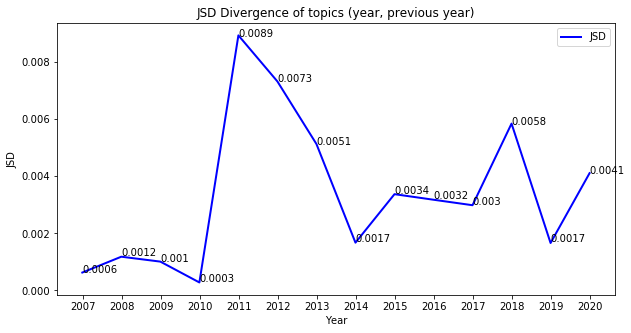

<Figure size 432x288 with 0 Axes>

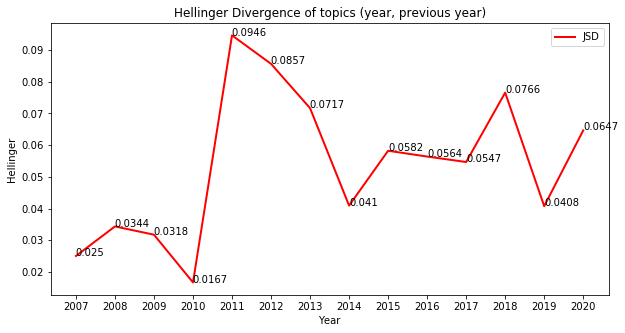

In [101]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import matplotlib.pyplot as plt


year_range = range(2006, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    distributions.append(lda_model[lda_model.id2word.doc2bow(cur_corpus)])

# Divergence (year, previous year)
for i in range(1, len(year_range)):
    divergence_hellinger.append(hellinger(distributions[i], distributions[i-1]))
    divergence_jsd.append(jensen_shannon(distributions[i], distributions[i-1]))

# JSD Divergence
width = 0.01
xlocs = [i for i in year_range[1:]]

plt.clf()
plt.figure(figsize=(10,5))
plt.title("JSD Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("JSD")

for x, y in enumerate([round(c, 4) for c in divergence_jsd]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_jsd, color='blue', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_jsd.png"))
plt.show()

# Hellinger divergence
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Hellinger Divergence of topics (year, previous year)")
plt.xlabel("Year") 
plt.ylabel("Hellinger")

for x, y in enumerate([round(c, 4) for c in divergence_hellinger]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range[1:]],
           year_range[1:])

plt.plot(year_range[1:], divergence_hellinger, color='red', linewidth=2, label="JSD")
plt.legend(loc="best")
plt.savefig(Path(target,"divergence_hellinger.png"))
plt.show()

## Calculate the divergence between papers for from a year to previous years

<Figure size 432x288 with 0 Axes>

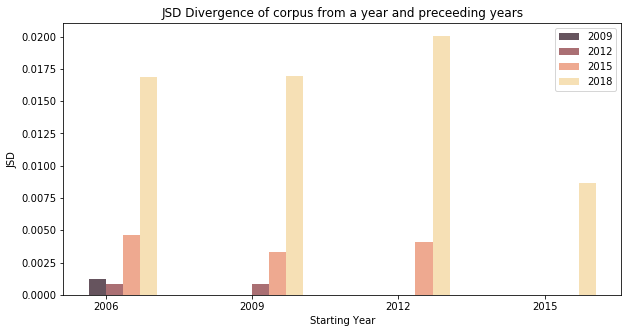

<Figure size 432x288 with 0 Axes>

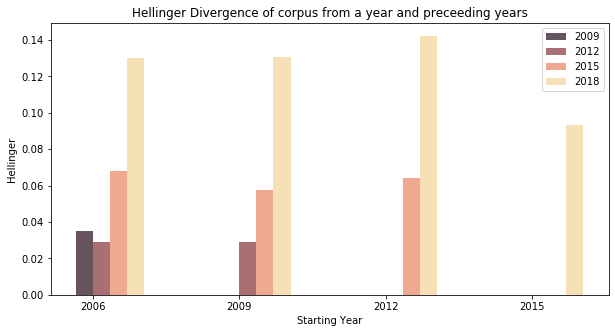

In [102]:
from gensim.matutils import jensen_shannon, hellinger
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import matplotlib.pyplot as plt
import random


year_range = range(2006, 2021, 3)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

lda_model = LdaModel.load(str(Path(model_dir, "all.gensim")))
distributions = []
colors = [(102,84,94), (170,111,115), (238,169,144), (246,224,181)]
colors = [(r/255,g/255,b/255) for (r,g,b) in colors]
divergence_hellinger = []
divergence_jsd = []

for year in year_range:
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    cur_corpus = [token for sentence in cur_corpus for token in sentence]
    distributions.append(lda_model[lda_model.id2word.doc2bow(cur_corpus)])

# Divergence (year, previous year)
for i in range(0, len(year_range)-1):
    cur_div_hell = []
    cur_div_jsd = []
    for j in range(1, len(year_range)):
        if (i < j):
            cur_div_hell.append(hellinger(distributions[j], distributions[i]))
            cur_div_jsd.append(jensen_shannon(distributions[j], distributions[i]))
        else:
            cur_div_jsd.append(0)
            cur_div_hell.append(0)
    divergence_hellinger.append(cur_div_hell)
    divergence_jsd.append(cur_div_jsd)


# Print the JSD for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("JSD Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("JSD")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_jsd]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "jsd_preceeding_years.png"))
plt.show()

# Print the hellinger for a year and preceeding years
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Hellinger Divergence of corpus from a year and preceeding years")
plt.xlabel("Starting Year") 
plt.ylabel("Hellinger")

width = 0.35
xlocs = [i for i in year_range[:-1]]
for i in range(0, len(year_range)-1):
    vals = [div[i] for div in divergence_hellinger]
    plt.bar([year + width*i for year in year_range[:-1]], vals, width, label=str(year_range[i+1]), 
            color = colors[i])
    
plt.xticks([year + width/2 for year in year_range[:-1]], year_range[:-1])
plt.legend(loc="best")
plt.savefig(Path(target, "hellinger_preceeding_years.png"))
plt.show()

Getting coherence & perplexity scores for 2006
Getting coherence & perplexity scores for 2007
Getting coherence & perplexity scores for 2008
Getting coherence & perplexity scores for 2009
Getting coherence & perplexity scores for 2010
Getting coherence & perplexity scores for 2011
Getting coherence & perplexity scores for 2012
Getting coherence & perplexity scores for 2013
Getting coherence & perplexity scores for 2014
Getting coherence & perplexity scores for 2015
Getting coherence & perplexity scores for 2016
Getting coherence & perplexity scores for 2017
Getting coherence & perplexity scores for 2018
Getting coherence & perplexity scores for 2019
Getting coherence & perplexity scores for 2020


<Figure size 432x288 with 0 Axes>

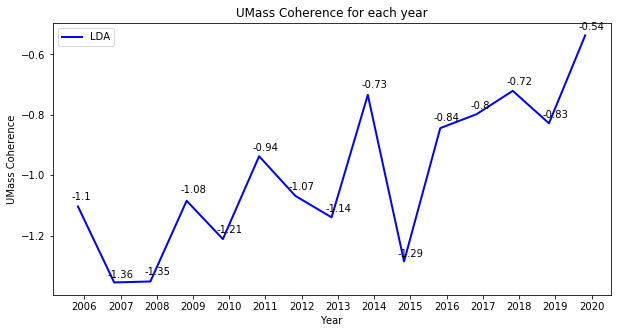

<Figure size 432x288 with 0 Axes>

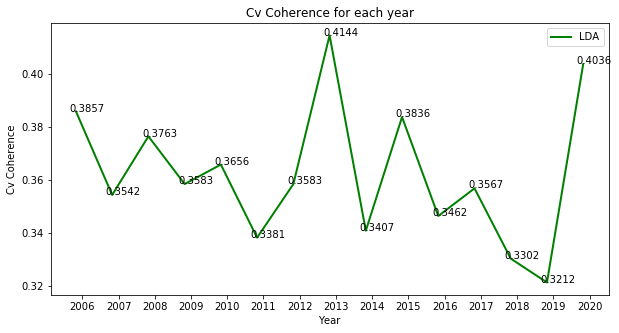

<Figure size 432x288 with 0 Axes>

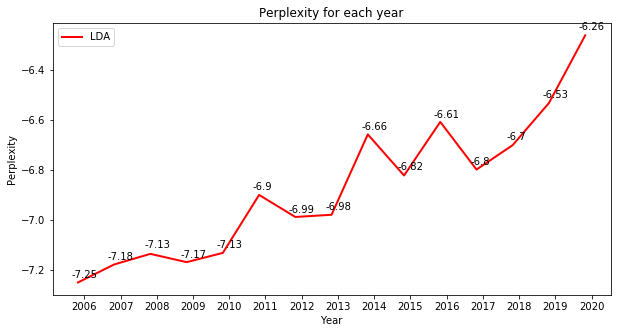

In [104]:
from gensim.models import LdaModel
from gensim.test.utils import datapath
from pathlib import Path

import matplotlib.pyplot as plt


year_range = range(2006, 2021)
model_dir = str(Path("../data/LDA/final").resolve())
input_dir = str(Path("../data/preprocessed").resolve())
target = str(Path("../data/LDA/final").resolve())

if not os.path.exists(target):
    os.makedirs(target)

coherence_umass = []
coherence_cv = []
perplexity = []

target = str(target)
if not os.path.exists(target):
    os.makedirs(target)

for year in year_range:
    print("Getting coherence & perplexity scores for", year)
    cur_corpus = []
    input_file = Path(input_dir, str(year) + ".pickle")
    with open(input_file, "rb") as file:
        cur_corpus = pickle.load(file)
    
    dictionary = TopicModeler.create_dictionary(cur_corpus, no_above=no_above)
    bow_corpus = TopicModeler.create_bow(cur_corpus, dictionary)
    lda_model = LdaModel.load(str(Path(model_dir, str(year) + ".gensim")))
    
    coherence_umass.append(TopicModeler.get_coherence_umass(lda_model, bow_corpus))
    coherence_cv.append(TopicModeler.get_coherence_cv(lda_model, cur_corpus, dictionary))
    perplexity.append(TopicModeler.get_perplexity(lda_model, bow_corpus))

    
# Visualize the results
width = 0.35
xlocs = [i for i in year_range]

## Coherence UMass
plt.clf()
plt.figure(figsize=(10,5))
plt.title("UMass Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("UMass Coherence")

for x, y in enumerate([round(c, 2) for c in coherence_umass]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_umass, color='blue', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_umass.png"))
plt.show()

## Coherence Cv
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Cv Coherence for each year")
plt.xlabel("Year") 
plt.ylabel("Cv Coherence")

for x, y in enumerate([round(c, 4) for c in coherence_cv]):
    plt.text(xlocs[x] - width/2, y, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, coherence_cv, color='green', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target,"years-coherence_cv.png"))
plt.show()

## Perplexity
plt.clf()
plt.figure(figsize=(10,5))
plt.title("Perplexity for each year")
plt.xlabel("Year") 
plt.ylabel("Perplexity")

for x, y in enumerate([round(p, 2) for p in perplexity]):
    plt.text(xlocs[x] - width/2, y + .02, str(y))
plt.xticks([num + width/2 for num in year_range],
           year_range)

plt.plot(year_range, perplexity, color='red', linewidth=2, label="LDA")
plt.legend(loc="best")
plt.savefig(Path(target, "years-perplexity.png"))
plt.show()